In [2]:
!pip install catboost
!pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap

from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor, Pool

In [4]:
base_dir = Path("data")
fp = base_dir / "faers_integration_batch_001.parquet"

df = pd.read_parquet(fp, engine="pyarrow")

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())


Shape: (1510448, 20)

Dtypes:
 case_id                    int64
drug                      object
gene                      object
expr_liver               float64
expr_kidney              float64
expr_colon               float64
expr_intestine           float64
expr_blood               float64
age                      float64
sex                       object
evidence_level            object
association_type          object
approval_year              int64
regulatory_complexity    float64
event_count                int64
has_severe_event            bool
has_cardiac_event           bool
has_gi_event                bool
max_severity              object
event_categories          object
dtype: object

Missing values:
 case_id                       0
drug                          0
gene                          0
expr_liver                    0
expr_kidney                   0
expr_colon                    0
expr_intestine                0
expr_blood                    0
age                  

In [5]:
print("event_count summary:\n")
print(df["event_count"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))


event_count summary:

count    1.510448e+06
mean     2.337722e+01
std      2.432522e+02
min      1.000000e+00
50%      3.000000e+00
75%      7.000000e+00
90%      2.000000e+01
95%      4.500000e+01
99%      3.780000e+02
max      4.990000e+04
Name: event_count, dtype: float64


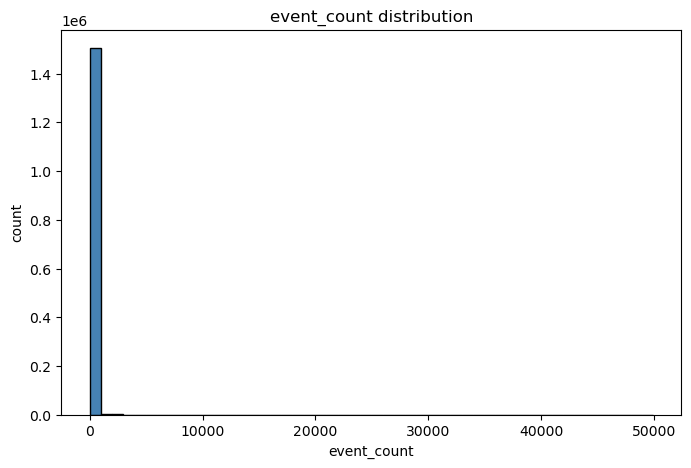

Unique event_count values: 1974
Most common values:
 event_count
1     356238
2     295841
3     160390
4     141284
6      79973
5      70323
8      48684
7      37064
10     31311
12     27397
Name: count, dtype: int64


In [6]:
plt.figure(figsize=(8,5))
plt.hist(df["event_count"], bins=50, color='steelblue', edgecolor='black')
plt.xlabel("event_count")
plt.ylabel("count")
plt.title("event_count distribution")
plt.show()

print("Unique event_count values:", df["event_count"].nunique())
print("Most common values:\n", df["event_count"].value_counts().head(10))


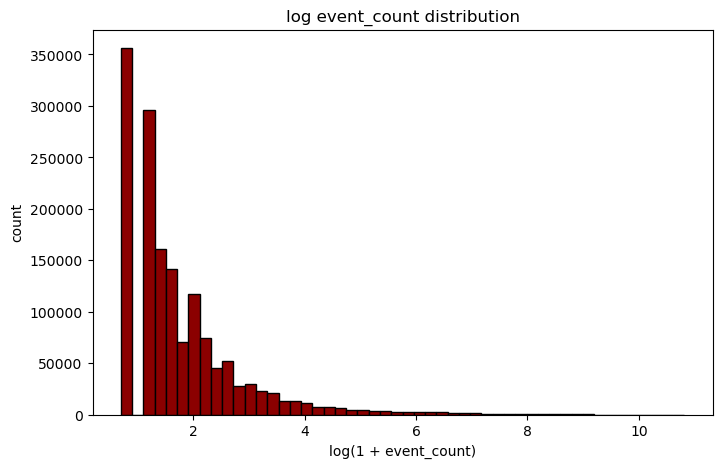

log event_count summary:
 count    1.510448e+06
mean     1.695942e+00
std      1.090067e+00
min      6.931472e-01
25%      1.098612e+00
50%      1.386294e+00
75%      2.079442e+00
max      1.081780e+01
Name: event_count, dtype: float64


In [7]:
vals = df["event_count"].replace(0, np.nan)
log_vals = np.log1p(vals.dropna())

plt.figure(figsize=(8,5))
plt.hist(log_vals, bins=50, color='darkred', edgecolor='black')
plt.xlabel("log(1 + event_count)")
plt.ylabel("count")
plt.title("log event_count distribution")
plt.savefig('distribution_of_event_count.png')
plt.show()

print("log event_count summary:\n", log_vals.describe())


In [8]:
q = df["event_count"].quantile([0.5,0.75,0.9,0.95,0.99])
print("Quantiles:\n", q)


Quantiles:
 0.50      3.0
0.75      7.0
0.90     20.0
0.95     45.0
0.99    378.0
Name: event_count, dtype: float64


Numeric summary:
          expr_liver   expr_kidney    expr_colon  expr_intestine    expr_blood  \
count  1.510448e+06  1.510448e+06  1.510448e+06    1.510448e+06  1.510448e+06   
mean   7.606481e+01  2.413458e+01  3.063345e+01    4.682622e+01  9.730555e+01   
std    2.343585e+02  1.099556e+02  1.515314e+02    2.385454e+02  8.045443e+02   
min    0.000000e+00  0.000000e+00  4.017557e-04    1.318527e-03  3.929564e-04   
25%    4.342294e-01  1.112716e+00  8.766449e-01    1.633677e+00  4.186601e-02   
50%    5.204763e+00  5.084233e+00  4.014709e+00    9.215442e+00  9.909171e-01   
75%    2.472168e+01  1.219710e+01  2.066909e+01    2.544167e+01  6.013350e+00   
max    2.189972e+03  1.231924e+03  1.751141e+03    2.830484e+03  9.209873e+03   

                age  approval_year  regulatory_complexity  
count  1.122874e+06   1.510448e+06           1.510448e+06  
mean   5.265933e+01   1.998925e+03           2.185683e+00  
std    2.111710e+01   1.772196e+01           1.141451e+00  
min    0.000

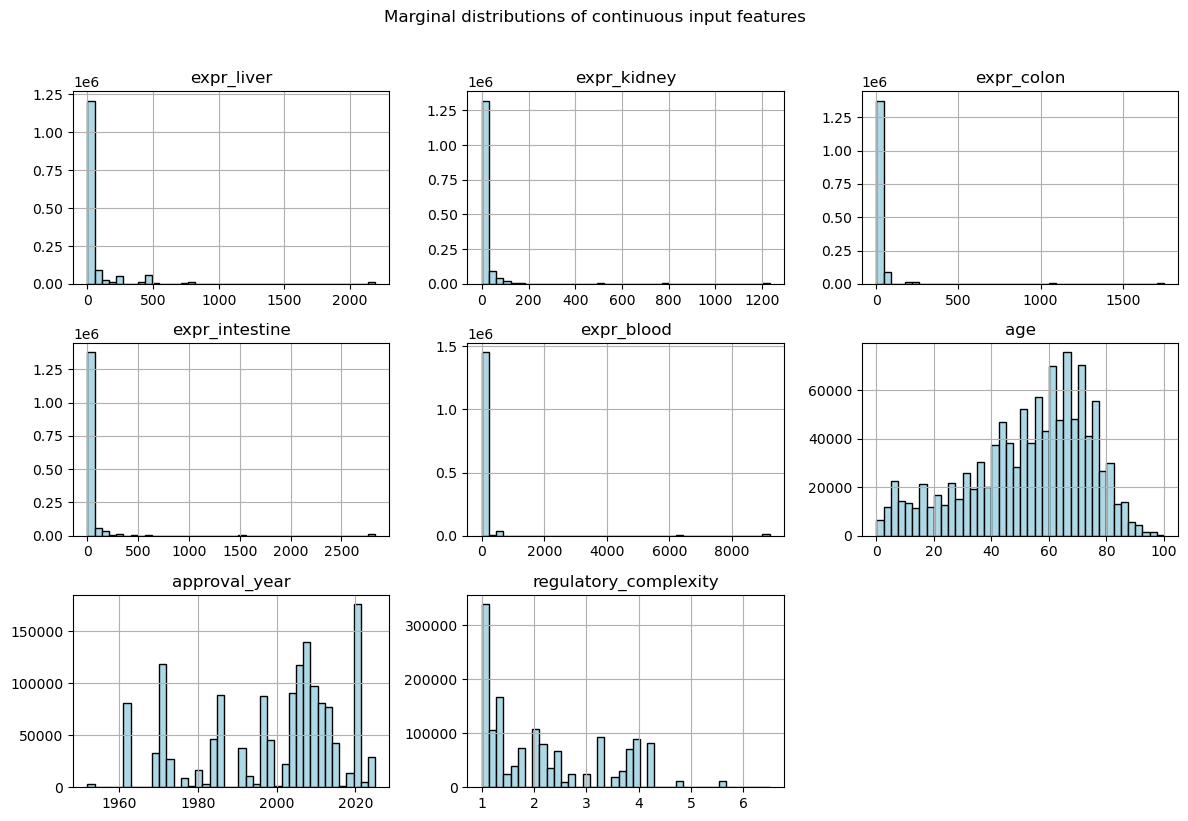

In [9]:
num_cols = [
    "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood",
    "age","approval_year","regulatory_complexity"
]

df[num_cols].hist(
    figsize=(12,8),
    bins=40,
    color='lightblue',
    edgecolor='black'
)

plt.suptitle("Marginal distributions of continuous input features", y=1.02)
plt.tight_layout()

plt.savefig(
    "fig_feature_histograms.png",
    dpi=300,
    bbox_inches="tight"
)

print("Numeric summary:\n", df[num_cols].describe())


In [10]:
print("Unique drugs:", df["drug"].nunique())
print("Top drugs:\n", df["drug"].value_counts().head(10))

print("\nUnique genes:", df["gene"].nunique())
print("Top genes:\n", df["gene"].value_counts().head(10))

print("\nSex distribution:\n", df["sex"].value_counts(dropna=False))


Unique drugs: 99
Top drugs:
 drug
methotrexate             160740
carboplatin               88680
fluorouracil              81040
prednisone                72672
clozapine                 71196
tacrolimus                67542
mycophenolate mofetil     60639
gemcitabine               50274
allopurinol               46755
olanzapine                43996
Name: count, dtype: int64

Unique genes: 150
Top genes:
 gene
BMP7       72867
UGT1A6     55770
MTRR       40185
ADORA2A    40185
ARID5B     40185
CYP2C9     37154
ERCC1      35370
PYGL       34679
TCF7L2     34167
CYP2D6     30152
Name: count, dtype: int64

Sex distribution:
 sex
F       708002
M       588186
None    212081
UNK       2179
Name: count, dtype: int64


In [11]:
print(df[num_cols + ["drug","gene","sex"]].isna().sum())


expr_liver                    0
expr_kidney                   0
expr_colon                    0
expr_intestine                0
expr_blood                    0
age                      387574
approval_year                 0
regulatory_complexity         0
drug                          0
gene                          0
sex                      212081
dtype: int64


/tmp/ipykernel_1684/2844289730.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()


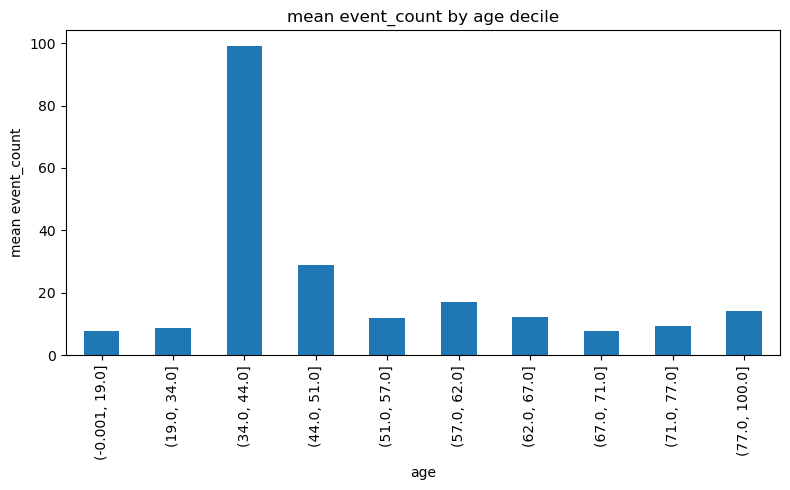

mean event_count by age decile:
 age
(-0.001, 19.0]     7.713060
(19.0, 34.0]       8.811320
(34.0, 44.0]      99.150274
(44.0, 51.0]      28.938361
(51.0, 57.0]      11.919644
(57.0, 62.0]      17.090977
(62.0, 67.0]      12.167482
(67.0, 71.0]       7.798239
(71.0, 77.0]       9.329608
(77.0, 100.0]     14.173072
Name: event_count, dtype: float64


In [12]:
# FIGURE: eventcount_by_age_decile
# LaTeX: fig_eventcount_by_age_decile.png
# Description: mean event_count stratified by age decile

bins = pd.qcut(df["age"], q=10, duplicates='drop')
grp = df.groupby(bins)["event_count"].mean()

plt.figure(figsize=(8,5))
grp.plot(kind='bar')

plt.title("mean event_count by age decile")
plt.ylabel("mean event_count")
plt.tight_layout()

plt.savefig(
    "fig_eventcount_by_age_decile.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

print("mean event_count by age decile:\n", grp)


/tmp/ipykernel_1684/1558559231.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()


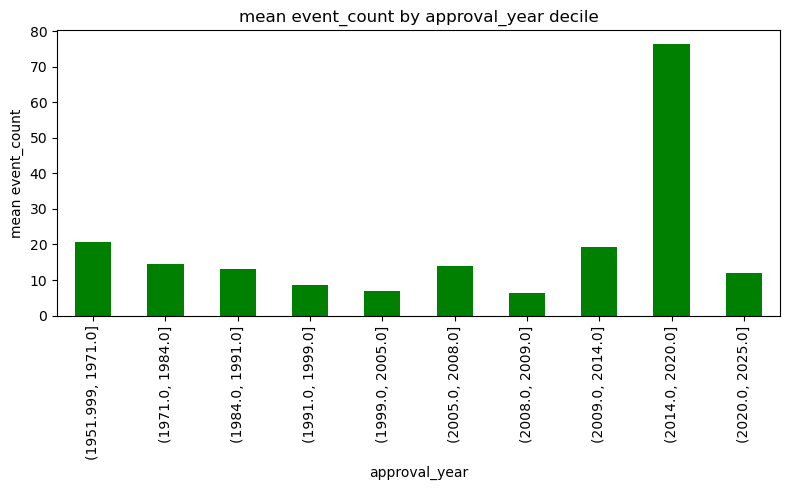

mean event_count by approval_year decile:
 approval_year
(1951.999, 1971.0]    20.803976
(1971.0, 1984.0]      14.497368
(1984.0, 1991.0]      13.076580
(1991.0, 1999.0]       8.543477
(1999.0, 2005.0]       6.880062
(2005.0, 2008.0]      13.971196
(2008.0, 2009.0]       6.269381
(2009.0, 2014.0]      19.319137
(2014.0, 2020.0]      76.421306
(2020.0, 2025.0]      12.077736
Name: event_count, dtype: float64


In [13]:
# FIGURE: eventcount_by_approval_decile
# LaTeX: fig_eventcount_by_approval_decile.png
# Description: mean event_count stratified by approval_year decile

bins = pd.qcut(df["approval_year"], q=10, duplicates='drop')
grp = df.groupby(bins)["event_count"].mean()

plt.figure(figsize=(8,5))
grp.plot(kind='bar', color='green')

plt.title("mean event_count by approval_year decile")
plt.ylabel("mean event_count")
plt.tight_layout()

plt.savefig(
    "fig_eventcount_by_approval_decile.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


print("mean event_count by approval_year decile:\n", grp)


/tmp/ipykernel_1684/455077344.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()


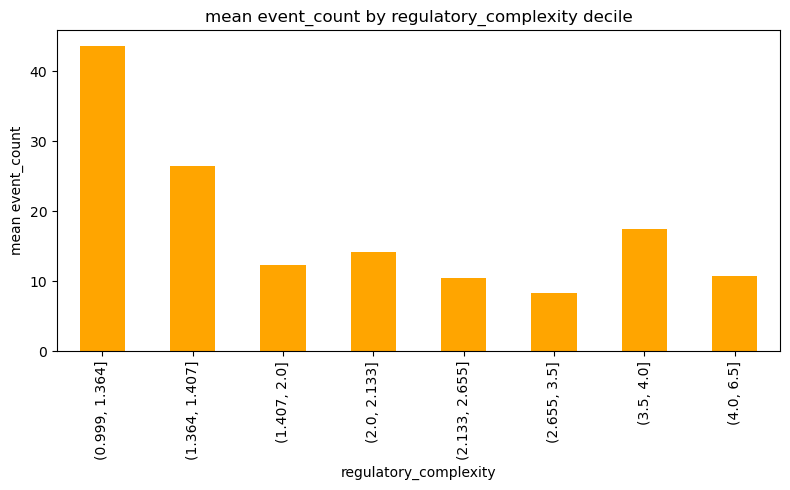

mean event_count by regulatory_complexity decile:
 regulatory_complexity
(0.999, 1.364]    43.656391
(1.364, 1.407]    26.452832
(1.407, 2.0]      12.340834
(2.0, 2.133]      14.108927
(2.133, 2.655]    10.422363
(2.655, 3.5]       8.334891
(3.5, 4.0]        17.509440
(4.0, 6.5]        10.707938
Name: event_count, dtype: float64


In [14]:
# FIGURE: eventcount_by_regulatory_complexity
# LaTeX: fig_eventcount_by_regulatory_complexity.png
# Description: mean event_count stratified by regulatory_complexity decile

bins = pd.qcut(df["regulatory_complexity"], q=10, duplicates='drop')
grp = df.groupby(bins)["event_count"].mean()

plt.figure(figsize=(8,5))
grp.plot(kind='bar', color='orange')

plt.title("mean event_count by regulatory_complexity decile")
plt.ylabel("mean event_count")
plt.tight_layout()

plt.savefig(
    "fig_eventcount_by_regulatory_complexity.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

print("mean event_count by regulatory_complexity decile:\n", grp)


/tmp/ipykernel_1684/902693665.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()


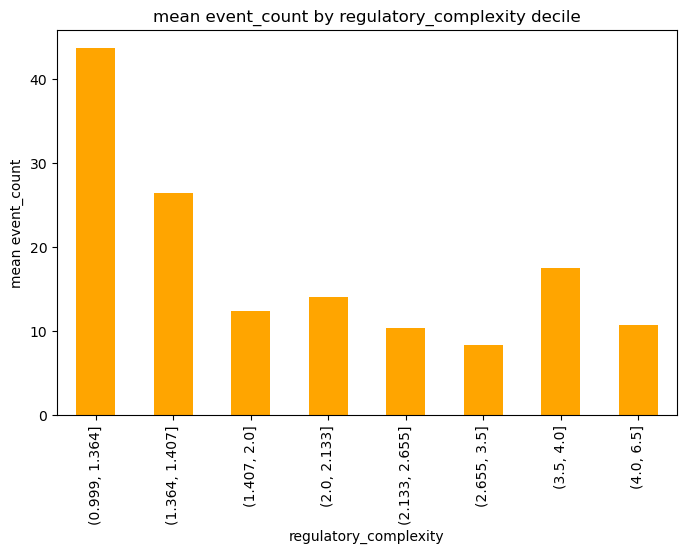

mean event_count by regulatory_complexity decile:
 regulatory_complexity
(0.999, 1.364]    43.656391
(1.364, 1.407]    26.452832
(1.407, 2.0]      12.340834
(2.0, 2.133]      14.108927
(2.133, 2.655]    10.422363
(2.655, 3.5]       8.334891
(3.5, 4.0]        17.509440
(4.0, 6.5]        10.707938
Name: event_count, dtype: float64


In [15]:
bins = pd.qcut(df["regulatory_complexity"], q=10, duplicates='drop')
grp = df.groupby(bins)["event_count"].mean()

plt.figure(figsize=(8,5))
grp.plot(kind='bar', color='orange')
plt.title("mean event_count by regulatory_complexity decile")
plt.ylabel("mean event_count")
plt.show()

print("mean event_count by regulatory_complexity decile:\n", grp)


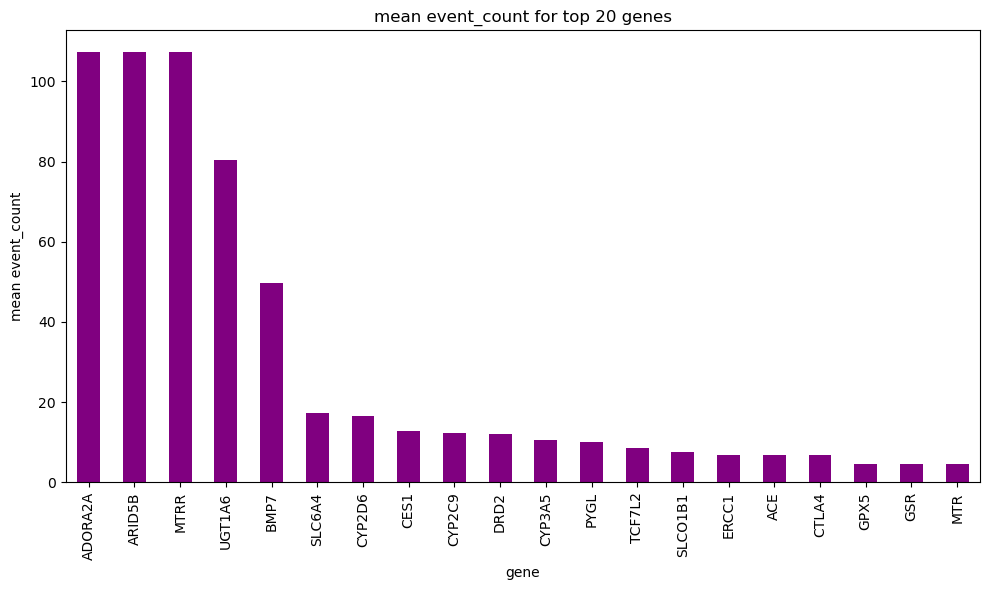

mean event_count for top 20 genes:
 gene
ADORA2A    107.333035
ARID5B     107.333035
MTRR       107.333035
UGT1A6      80.313627
BMP7        49.819054
SLC6A4      17.345541
CYP2D6      16.674018
CES1        12.893348
CYP2C9      12.223987
DRD2        11.963571
CYP3A5      10.589479
PYGL        10.120275
TCF7L2       8.514093
SLCO1B1      7.703671
ERCC1        6.793186
ACE          6.746824
CTLA4        6.746824
GPX5         4.693054
GSR          4.693054
MTR          4.693054
Name: event_count, dtype: float64


In [16]:
# FIGURE: eventcount_top20_genes
# LaTeX: fig_eventcount_top20_genes.png
# Description: mean event_count aggregated over top 20 most frequent genes

top_genes = df["gene"].value_counts().head(20).index
sub = df[df["gene"].isin(top_genes)]

grp = (
    sub.groupby("gene")["event_count"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
grp.plot(kind='bar', color='purple')

plt.title("mean event_count for top 20 genes")
plt.ylabel("mean event_count")
plt.tight_layout()

plt.savefig(
    "fig_eventcount_top20_genes.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


print("mean event_count for top 20 genes:\n", grp)


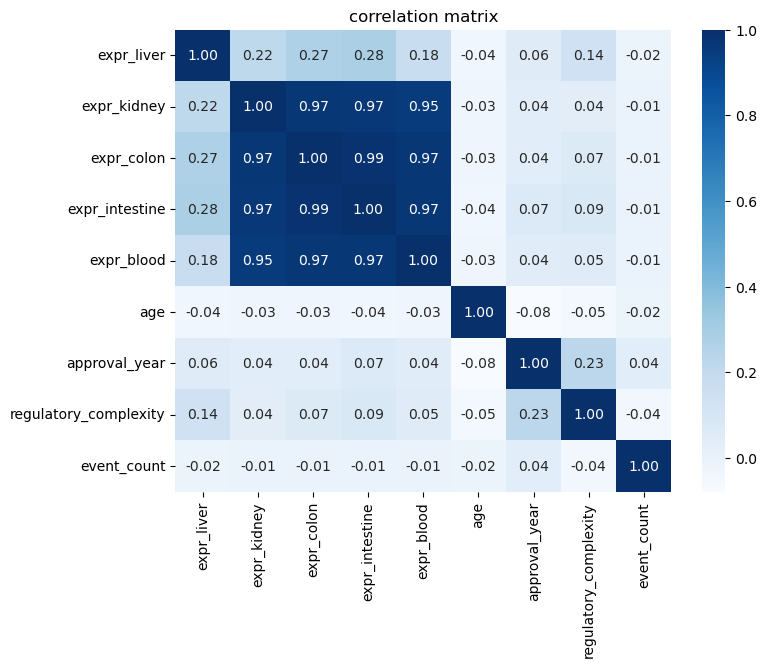

correlation values:
 event_count              1.000000
approval_year            0.041481
expr_blood              -0.006032
expr_colon              -0.007285
expr_intestine          -0.008189
expr_kidney             -0.008834
age                     -0.016101
expr_liver              -0.016476
regulatory_complexity   -0.044095
Name: event_count, dtype: float64


In [17]:
corr_cols = num_cols + ["event_count"]
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("correlation matrix")
plt.show()

print("correlation values:\n", corr["event_count"].sort_values(ascending=False))


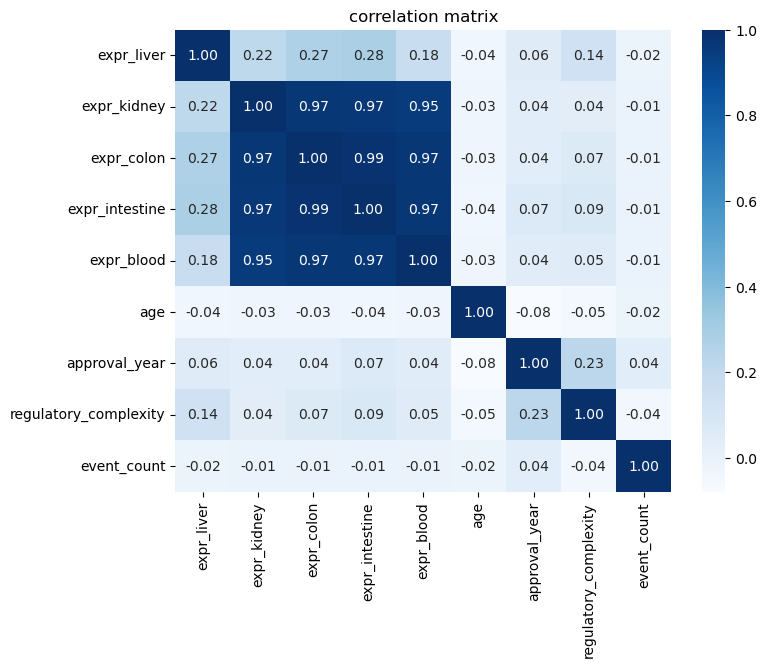

correlation values:
 event_count              1.000000
approval_year            0.041481
expr_blood              -0.006032
expr_colon              -0.007285
expr_intestine          -0.008189
expr_kidney             -0.008834
age                     -0.016101
expr_liver              -0.016476
regulatory_complexity   -0.044095
Name: event_count, dtype: float64


In [18]:
corr_cols = num_cols + ["event_count"]
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("correlation matrix")
plt.show()

print("correlation values:\n", corr["event_count"].sort_values(ascending=False))



expr_liver decile means:
 expr_liver
(-0.001, 0.0279]       24.560442
(0.0279, 0.138]        13.892922
(0.138, 0.95]          13.062712
(0.95, 3.933]          37.140075
(3.933, 5.205]         63.390359
(5.205, 10.437]        30.728524
(10.437, 17.321]       14.589221
(17.321, 51.902]       10.939410
(51.902, 244.087]      10.714281
(244.087, 2189.972]    10.501902
Name: event_count, dtype: float64


/tmp/ipykernel_1684/3579025784.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()


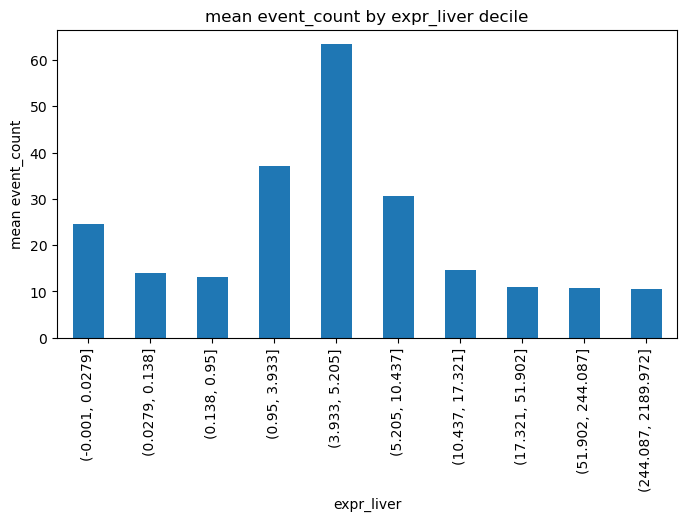


expr_kidney decile means:
 expr_kidney
(-0.001, 0.0831]      13.630996
(0.0831, 0.572]       13.245196
(0.572, 1.621]        12.575366
(1.621, 3.052]        14.692763
(3.052, 5.084]        49.000441
(5.084, 6.82]          8.505637
(6.82, 10.51]         52.154059
(10.51, 14.532]       41.955078
(14.532, 36.466]      11.646912
(36.466, 1231.924]     8.424670
Name: event_count, dtype: float64


/tmp/ipykernel_1684/3579025784.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()


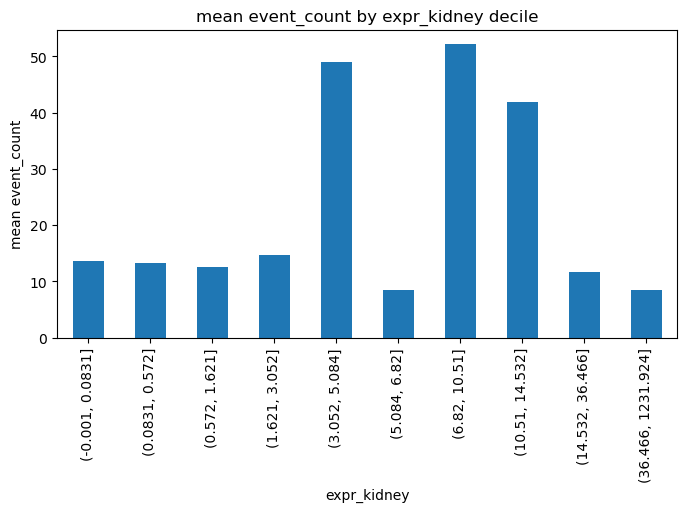

/tmp/ipykernel_1684/3579025784.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()



expr_colon decile means:
 expr_colon
(-0.000598, 0.0845]     8.062013
(0.0845, 0.441]        39.272519
(0.441, 1.988]         15.395338
(1.988, 2.956]         25.104953
(2.956, 4.015]         51.268943
(4.015, 12.111]        10.182533
(12.111, 18.307]       35.525920
(18.307, 22.874]       32.600660
(22.874, 41.339]       10.774023
(41.339, 1751.141]     11.141253
Name: event_count, dtype: float64


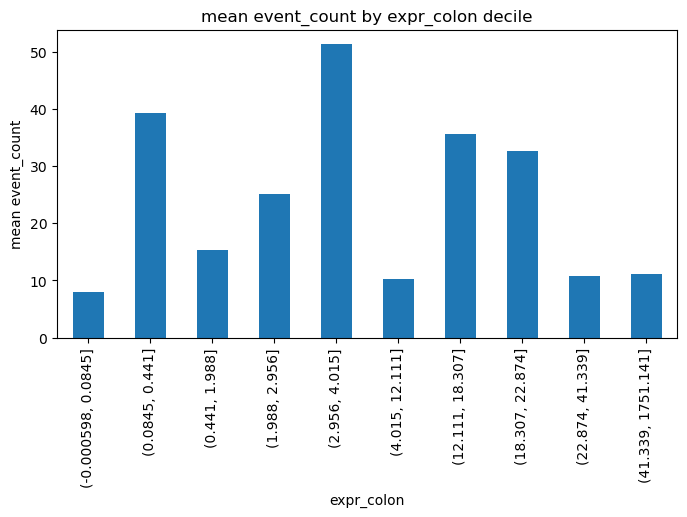

/tmp/ipykernel_1684/3579025784.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()



expr_intestine decile means:
 expr_intestine
(0.00031999999999999997, 0.174]     8.644724
(0.174, 0.611]                     38.672780
(0.611, 2.521]                     28.462885
(2.521, 4.933]                     10.240600
(4.933, 9.215]                     37.815021
(9.215, 14.852]                    34.787219
(14.852, 22.083]                    9.657160
(22.083, 30.109]                   35.874145
(30.109, 70.177]                    9.959751
(70.177, 2830.484]                 11.036334
Name: event_count, dtype: float64


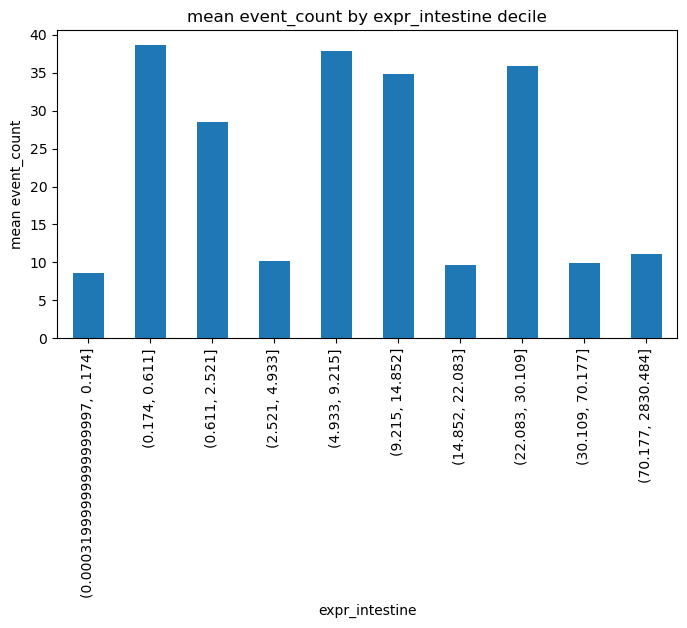

/tmp/ipykernel_1684/3579025784.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)["event_count"].mean()



expr_blood decile means:
 expr_blood
(-0.000607, 0.00999]    35.010457
(0.00999, 0.0312]       27.084391
(0.0312, 0.107]         16.837646
(0.107, 0.305]          16.786545
(0.305, 0.991]          10.054323
(0.991, 2.307]           9.059689
(2.307, 4.587]          33.015712
(4.587, 8.888]          37.993154
(8.888, 34.905]         34.782937
(34.905, 9209.873]       8.143731
Name: event_count, dtype: float64


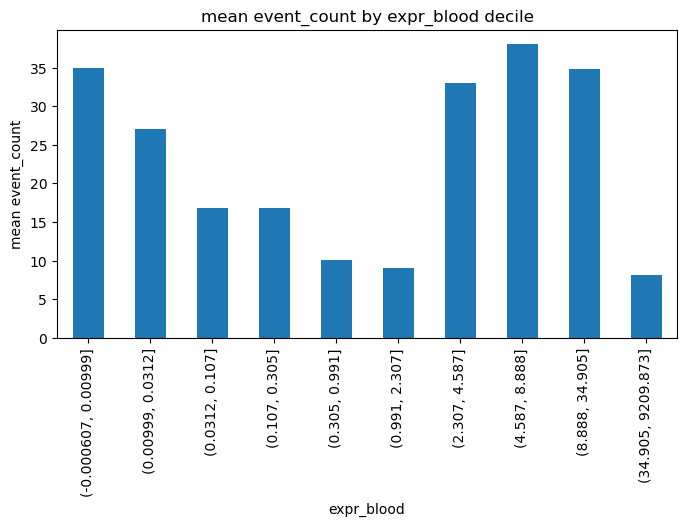

In [19]:
expr_cols = ["expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"]

for c in expr_cols:
    bins = pd.qcut(df[c], q=10, duplicates='drop')
    grp = df.groupby(bins)["event_count"].mean()
    print(f"\n{c} decile means:\n", grp)

    plt.figure(figsize=(8,4))
    grp.plot(kind='bar')
    plt.title(f"mean event_count by {c} decile")
    plt.ylabel("mean event_count")
    plt.show()


In [20]:
# Columns to remove
drop_cols = [
    "case_id",
    "evidence_level",
    "association_type",
    "has_severe_event",
    "has_cardiac_event",
    "has_gi_event",
    "max_severity",
    "event_categories"
]

# Features for Model 1
num_features = [
    "age", "approval_year", "regulatory_complexity",
    "expr_liver", "expr_kidney", "expr_colon", "expr_intestine", "expr_blood"
]

cat_features = [
    "sex", "drug", "gene"
]

target_col = "event_count"


In [21]:
df1 = df.drop(columns=drop_cols)

print("New shape:", df1.shape)
print("Columns kept:", df1.columns.tolist())
print(df1[num_features + cat_features].isna().sum())


New shape: (1510448, 12)
Columns kept: ['drug', 'gene', 'expr_liver', 'expr_kidney', 'expr_colon', 'expr_intestine', 'expr_blood', 'age', 'sex', 'approval_year', 'regulatory_complexity', 'event_count']
age                      387574
approval_year                 0
regulatory_complexity         0
expr_liver                    0
expr_kidney                   0
expr_colon                    0
expr_intestine                0
expr_blood                    0
sex                      212081
drug                          0
gene                          0
dtype: int64


In [22]:
df_base = df1.copy()

# fill numeric
df_base["age"] = df_base["age"].fillna(df_base["age"].median())

# fill categorical
df_base["sex"] = df_base["sex"].fillna("Unknown")

print("Post-imputation missingness:\n", df_base[num_features + cat_features].isna().sum())


Post-imputation missingness:
 age                      0
approval_year            0
regulatory_complexity    0
expr_liver               0
expr_kidney              0
expr_colon               0
expr_intestine           0
expr_blood               0
sex                      0
drug                     0
gene                     0
dtype: int64


In [23]:
X_base = df_base[num_features + cat_features]
y_base = df_base[target_col]

print("X shape:", X_base.shape)
print("y shape:", y_base.shape)


X shape: (1510448, 11)
y shape: (1510448,)


In [24]:

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features)
    ]
)

ridge = Ridge(alpha=1.0)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", ridge)
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'approval_year',
                                                   'regulatory_complexity',
                                                   'expr_liver', 'expr_kidney',
                                                   'expr_colon',
                                                   'expr_intestine',
                                                   'expr_blood']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'drug', 'gene'])])),
                ('model', Ridge())])

In [25]:
# sample for baseline training
df_sample = df_base.sample(200_000, random_state=42)

X_s = df_sample[num_features + cat_features]
y_s = df_sample[target_col]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_s, y_s, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (160000, 11)
Test size: (40000, 11)


In [26]:
pipe.fit(X_train, y_train)

print("Baseline model trained.")


Baseline model trained.


In [27]:
pred = pipe.predict(X_test)

mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print("Baseline RMSE:", rmse)
print("Baseline MAE:", mae)
print("Baseline R2:", r2)

Baseline RMSE: 230.63811976744816
Baseline MAE: 38.1586384028784
Baseline R2: 0.022404888912705645


In [28]:
class BatchLoaderModel1:
    def __init__(self, base_dir="data", start=1, end=15):
        self.base_dir = Path(base_dir)
        self.start = start
        self.end = end
        self.num_features = ["age","approval_year","regulatory_complexity",
                             "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"]
        self.cat_features = ["sex","drug","gene"]
        self.target = "event_count"
        self.drop_cols = ["case_id","evidence_level","association_type",
                          "has_severe_event","has_cardiac_event","has_gi_event",
                          "max_severity","event_categories"]

    def iter_batches(self, frac=0.2):
        for i in range(self.start, self.end + 1):
            fp = self.base_dir / f"faers_integration_batch_{i:03d}.parquet"
            df = pd.read_parquet(fp, engine="pyarrow")
            df = df.sample(frac=frac, random_state=42)
            df = df.drop(columns=self.drop_cols)
            df["age"] = df["age"].fillna(df["age"].median())
            df["sex"] = df["sex"].fillna("Unknown")
            X = df[self.num_features + self.cat_features]
            y = np.log1p(df[self.target])
            yield X, y

In [29]:
loader = BatchLoaderModel1(start=1, end=15)
X_val, y_val = next(loader.iter_batches(frac=0.2))
val_idx = np.random.choice(len(X_val), size=10000, replace=False)
X_val_sub = X_val.iloc[val_idx]
y_val_sub = y_val.iloc[val_idx]

pool_val = Pool(X_val_sub, y_val_sub, cat_features=["sex", "drug", "gene"])
print("Validation size:", X_val_sub.shape)

Validation size: (10000, 11)


In [30]:
print("Loading all training batches...")
X_train_parts = []
y_train_parts = []

for X_batch, y_batch in loader.iter_batches(frac=0.2):
    X_train_parts.append(X_batch)
    y_train_parts.append(y_batch)

X_train = pd.concat(X_train_parts, ignore_index=True)
y_train = pd.Series(np.concatenate(y_train_parts))

print(f"Total training samples: {len(X_train):,}")

pool_train = Pool(X_train, y_train, cat_features=["sex", "drug", "gene"])

Loading all training batches...
Total training samples: 4,800,991


In [31]:
model = CatBoostRegressor(
    iterations=5000,           # you can go high — GPU is fast
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=3,
    border_count=254,
    bagging_temperature=1.0,
    random_strength=1,
    
    loss_function="RMSE",
    eval_metric="RMSE",
    metric_period=200,
    
    task_type="GPU",
    devices="0",
    boosting_type="Plain",
    
    random_seed=42,
    od_type="Iter",
    od_wait=100,
    verbose=200
)



In [32]:
model.fit(
    pool_train,
    eval_set=pool_val,
    use_best_model=True
)

final_rmse = model.get_best_score()["validation"]["RMSE"]
print(f"\nFinal validation RMSE (log-space): {final_rmse:.6f}")

0:	learn: 1.1485340	test: 1.0937072	best: 1.0937072 (0)	total: 101ms	remaining: 8m 23s
200:	learn: 1.0150197	test: 0.9766175	best: 0.9766175 (200)	total: 13.9s	remaining: 5m 31s
400:	learn: 1.0087562	test: 0.9687040	best: 0.9687040 (400)	total: 27.9s	remaining: 5m 20s
600:	learn: 1.0053559	test: 0.9639760	best: 0.9639760 (600)	total: 41.8s	remaining: 5m 6s
800:	learn: 1.0030871	test: 0.9606672	best: 0.9606672 (800)	total: 56s	remaining: 4m 53s
1000:	learn: 1.0014710	test: 0.9582648	best: 0.9582648 (1000)	total: 1m 10s	remaining: 4m 39s
1200:	learn: 1.0002324	test: 0.9564994	best: 0.9564994 (1200)	total: 1m 24s	remaining: 4m 26s
1400:	learn: 0.9991857	test: 0.9551355	best: 0.9551355 (1400)	total: 1m 38s	remaining: 4m 13s
1600:	learn: 0.9983328	test: 0.9540198	best: 0.9540198 (1600)	total: 1m 53s	remaining: 4m
1800:	learn: 0.9975510	test: 0.9530326	best: 0.9530326 (1800)	total: 2m 7s	remaining: 3m 46s
2000:	learn: 0.9968356	test: 0.9523501	best: 0.9523494 (1998)	total: 2m 22s	remaining: 

In [33]:
y_true = np.expm1(y_val_sub)
y_pred = np.expm1(model.predict(pool_val, 
                                prediction_type='RawFormulaVal', 
                                thread_count=8))

rmse_orig = np.sqrt(((y_true - y_pred) ** 2).mean())
mae_orig  = np.abs(y_true - y_pred).mean()

print("Validation RMSE (original units):", rmse_orig)
print("Validation MAE  (original units):", mae_orig)

Validation RMSE (original units): 193.68241172025154
Validation MAE  (original units): 19.86043949221039


In [34]:
model.save_model("model1_catboost.cbm")
print("Model saved.")


Model saved.


In [35]:
# log-space preds
pred_log = model.predict(pool_val)
res_log = y_val_sub - pred_log

print("Log-space residual summary:")
print(res_log.describe())

# original-space preds
pred_orig = np.expm1(pred_log)
res_orig  = y_true - pred_orig

print("\nOriginal-space residual summary:")
print(res_orig.describe())


Log-space residual summary:
count    10000.000000
mean         0.001521
std          0.947598
min         -4.429663
25%         -0.649000
50%         -0.194134
75%          0.461578
max          5.733125
Name: event_count, dtype: float64

Original-space residual summary:
count    10000.000000
mean        15.683658
std        193.056019
min       -190.334304
25%         -2.227061
50%         -0.799589
75%          2.932893
max      11785.337396
Name: event_count, dtype: float64


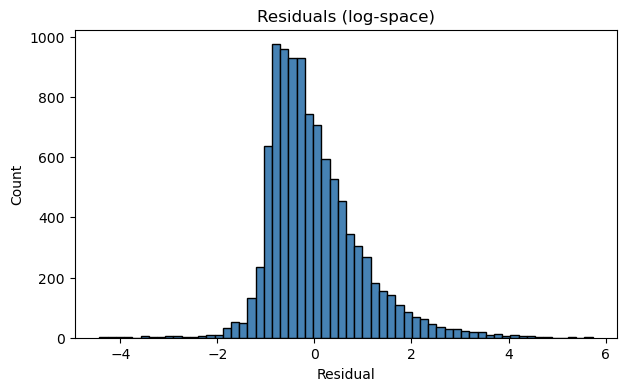

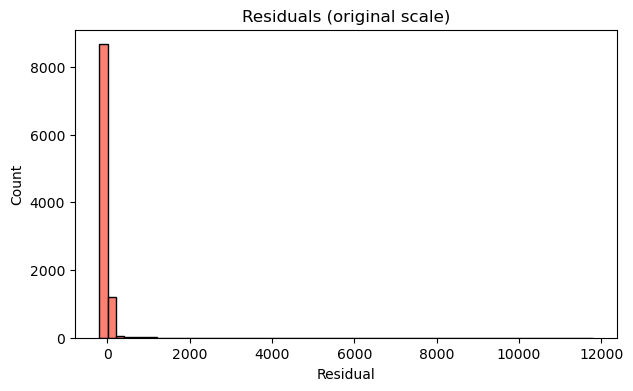

In [36]:
plt.figure(figsize=(7,4))
plt.hist(res_log, bins=60, color='steelblue', edgecolor='black')
plt.title("Residuals (log-space)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(res_orig, bins=60, color='salmon', edgecolor='black')
plt.title("Residuals (original scale)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


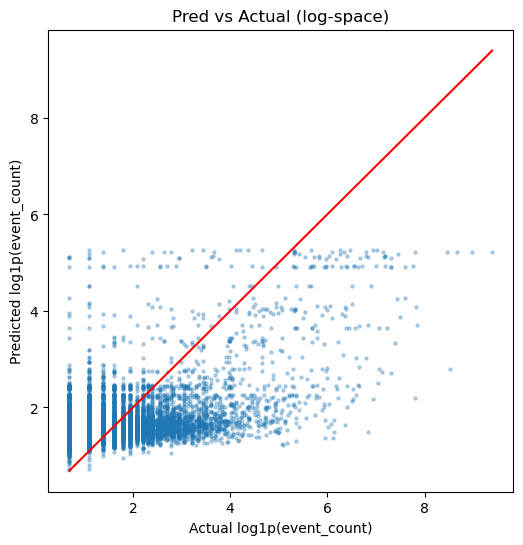

In [37]:
plt.figure(figsize=(6,6))
plt.scatter(y_val_sub, pred_log, s=5, alpha=0.3)
plt.xlabel("Actual log1p(event_count)")
plt.ylabel("Predicted log1p(event_count)")
plt.title("Pred vs Actual (log-space)")
plt.plot([y_val_sub.min(), y_val_sub.max()],
         [y_val_sub.min(), y_val_sub.max()], color='red')
plt.show()


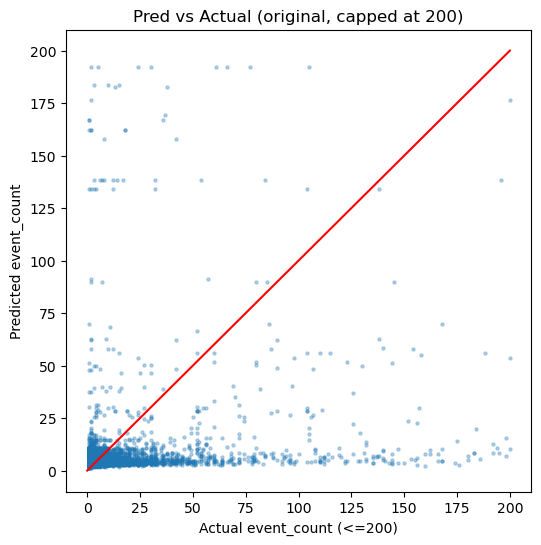

Percentage of points shown: 98.28


In [38]:
cap = 200  # adjust if needed

mask = y_true <= cap
plt.figure(figsize=(6,6))
plt.scatter(y_true[mask], pred_orig[mask], s=5, alpha=0.3)
plt.xlabel("Actual event_count (<=200)")
plt.ylabel("Predicted event_count")
plt.title("Pred vs Actual (original, capped at 200)")
plt.plot([0, cap], [0, cap], color='red')
plt.show()

print("Percentage of points shown:", mask.mean() * 100)


In [39]:
bins = [1, 5, 10, 20, 50, 100, 250, 1000, 5000]
groups = pd.cut(y_true, bins=bins, include_lowest=True)

df_cal = pd.DataFrame({
    "true": y_true,
    "pred": pred_orig,
    "bin": groups
})

cal = df_cal.groupby("bin").agg(["mean","median"])
print(cal)


                         true                pred            
                         mean  median        mean      median
bin                                                          
(0.999, 5.0]         2.284357     2.0    4.555251    3.679574
(5.0, 10.0]          7.165490     7.0    5.139744    4.025566
(10.0, 20.0]        13.659449    13.0    6.664674    4.193523
(20.0, 50.0]        31.158317    30.0    9.334096    4.578878
(50.0, 100.0]       68.637363    65.0   18.309948    6.837398
(100.0, 250.0]     154.891156   144.0   29.757177    8.504404
(250.0, 1000.0]    489.100917   432.0   64.870362   36.979064
(1000.0, 5000.0]  1689.733333  1489.0  101.767786  134.121607


/tmp/ipykernel_1684/1769688300.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df_cal.groupby("bin").agg(["mean","median"])


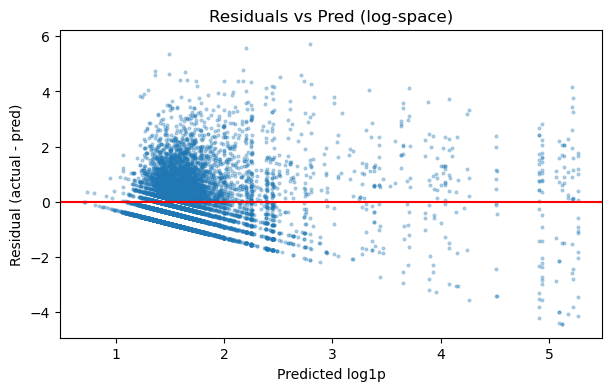

In [40]:
plt.figure(figsize=(7,4))
plt.scatter(pred_log, res_log, s=4, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("Predicted log1p")
plt.ylabel("Residual (actual - pred)")
plt.title("Residuals vs Pred (log-space)")
plt.show()


drug
methotrexate             82.740655
celecoxib                62.293518
prednisone               41.447921
allopurinol              22.375680
risperidone              18.620486
mycophenolate mofetil    12.699371
olanzapine               11.266477
atenolol                 11.104640
aripiprazole             10.316178
ondansetron               8.254987
fluorouracil              6.841835
clozapine                 6.708076
dexamethasone             6.569616
tacrolimus                5.258951
escitalopram              5.163909
cyclophosphamide          4.640337
cytarabine                4.341485
cisplatin                 3.946164
carboplatin               3.479561
gemcitabine               2.748410
Name: ae, dtype: float64


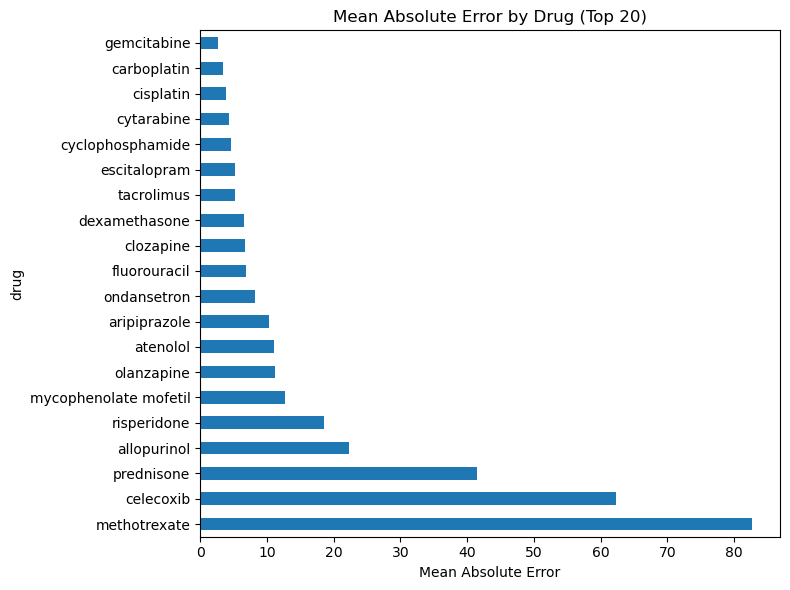

In [41]:
df_tmp = X_val_sub.copy()
df_tmp["true"] = y_true
df_tmp["pred"] = pred_orig
df_tmp["ae"]   = np.abs(df_tmp["true"] - df_tmp["pred"])

top_drugs = df_tmp["drug"].value_counts().head(20).index

drug_err = (
    df_tmp[df_tmp["drug"].isin(top_drugs)]
    .groupby("drug")["ae"]
    .mean()
    .sort_values(ascending=False)
)

print(drug_err)

plt.figure(figsize=(8,6))
drug_err.plot(kind='barh')
plt.xlabel("Mean Absolute Error")
plt.title("Mean Absolute Error by Drug (Top 20)")
plt.tight_layout()
plt.savefig(
    "fig_model1_mae_drug.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


gene
ARID5B     119.144979
UGT1A6      76.884464
ADORA2A     61.495314
MTRR        45.563131
BMP7        41.447921
TNF         13.516699
UGT1A9      12.798531
CYP2D6      12.102198
CYP3A5       9.356627
TCF7L2       7.891444
SLC6A4       7.269445
DRD2         7.042933
CYP2C9       7.042199
PYGL         6.569616
ACE          5.184333
CTLA4        4.180293
ERCC1        4.147852
GPX5         3.561603
SLCO1B1      3.091728
MTR          2.744357
Name: ae, dtype: float64


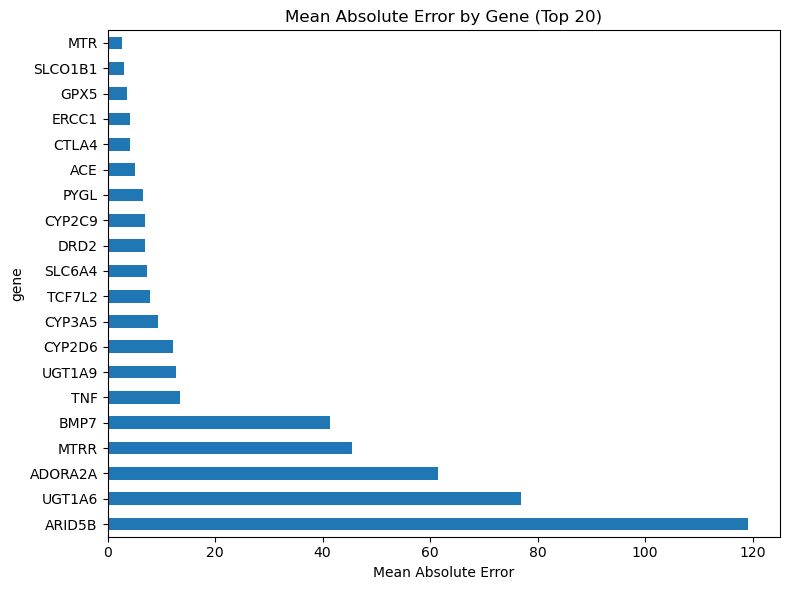

In [42]:
top_genes = df_tmp["gene"].value_counts().head(20).index

gene_err = (
    df_tmp[df_tmp["gene"].isin(top_genes)]
    .groupby("gene")["ae"]
    .mean()
    .sort_values(ascending=False)
)

print(gene_err)

plt.figure(figsize=(8,6))
gene_err.plot(kind='barh')
plt.xlabel("Mean Absolute Error")
plt.title("Mean Absolute Error by Gene (Top 20)")
plt.tight_layout()
plt.savefig(
    "fig_model1_mae_gene.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


rc_bin
(0.999, 1.292]    35.401857
(1.292, 1.407]    21.873435
(1.407, 2.0]      10.936079
(2.0, 2.133]       8.469694
(2.133, 2.655]     9.479464
(2.655, 3.5]       5.944846
(3.5, 4.0]        18.840095
(4.0, 5.636]      13.383472
Name: ae, dtype: float64


/tmp/ipykernel_1684/2538905608.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rc_err = df_tmp.groupby("rc_bin")["ae"].mean()


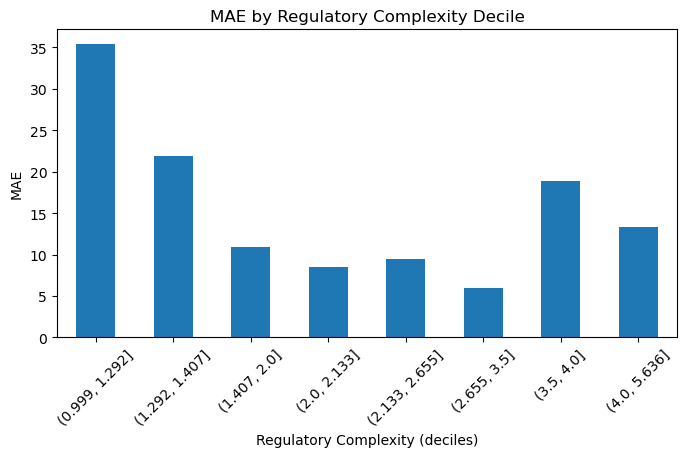

In [43]:
df_tmp["rc_bin"] = pd.qcut(
    df_tmp["regulatory_complexity"], 
    q=10, 
    duplicates='drop'
)

rc_err = df_tmp.groupby("rc_bin")["ae"].mean()
print(rc_err)

rc_err.plot(kind='bar', figsize=(8,4))
plt.title("MAE by Regulatory Complexity Decile")
plt.ylabel("MAE")
plt.xlabel("Regulatory Complexity (deciles)")
plt.xticks(rotation=45)
plt.show()

expr_liver_bin
(-0.001, 0.0279]       22.616478
(0.0279, 0.213]        11.550516
(0.213, 0.95]          13.387980
(0.95, 3.933]          47.270272
(3.933, 5.205]         46.888126
(5.205, 10.437]        17.026973
(10.437, 17.321]        9.499840
(17.321, 50.884]        9.253238
(50.884, 244.087]       8.583402
(244.087, 2189.972]     7.257590
Name: ae, dtype: float64


/tmp/ipykernel_1684/1219950580.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_err = df_tmp.groupby("expr_liver_bin")["ae"].mean()


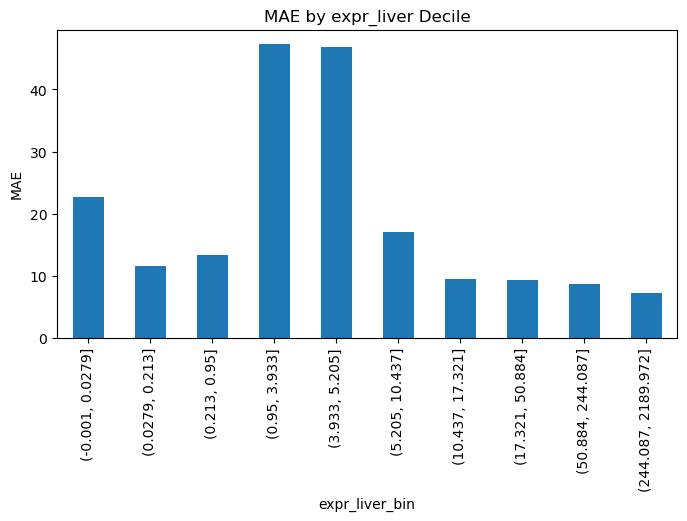

In [44]:
df_tmp["expr_liver_bin"] = pd.qcut(df_tmp["expr_liver"], q=10)

expr_err = df_tmp.groupby("expr_liver_bin")["ae"].mean()
print(expr_err)

plt.figure(figsize=(8,4))
expr_err.plot(kind='bar')
plt.title("MAE by expr_liver Decile")
plt.ylabel("MAE")
plt.show()


                  feature  importance
0                     age   57.857954
9                    drug   18.935339
8                     sex   13.110614
2   regulatory_complexity    5.239662
1           approval_year    3.205319
10                   gene    0.339879
7              expr_blood    0.321990
3              expr_liver    0.278522
4             expr_kidney    0.255913
5              expr_colon    0.233954
6          expr_intestine    0.220854


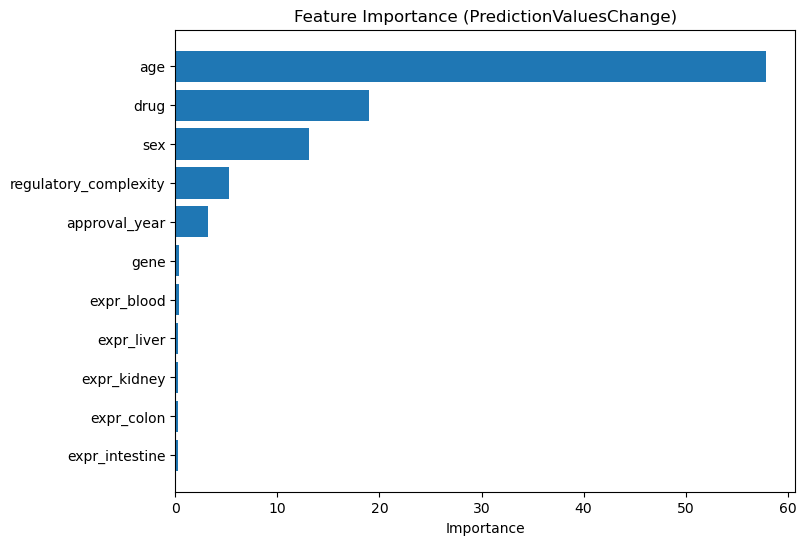

In [45]:
feat_names = X_train.columns.tolist()
imp_pred_change = model.get_feature_importance(
    data=pool_val, 
    type="PredictionValuesChange"
)

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": imp_pred_change
}).sort_values("importance", ascending=False)

print(imp_df)

plt.figure(figsize=(8,6))
plt.barh(imp_df["feature"].iloc[::-1], imp_df["importance"].iloc[::-1])
plt.title("Feature Importance (PredictionValuesChange)")
plt.xlabel("Importance")
plt.savefig('feature_importance_predictionvalueschange.png')
plt.show()


In [46]:
# imp_loss = model.get_feature_importance(
#     data=pool_val, 
#     type="LossFunctionChange"
# )

# imp_loss_df = pd.DataFrame({
#     "feature": feat_names,
#     "importance": imp_loss
# }).sort_values("importance", ascending=False)

# print(imp_loss_df)

# plt.figure(figsize=(8,6))
# plt.barh(imp_loss_df["feature"].iloc[::-1], imp_loss_df["importance"].iloc[::-1])
# plt.title("Feature Importance (LossFunctionChange)")
# plt.xlabel("Importance")
# plt.show()


                  feature  rmse_increase
9                    drug       0.167836
0                     age       0.163175
8                     sex       0.098006
2   regulatory_complexity       0.014977
1           approval_year       0.008703
5              expr_colon       0.001791
6          expr_intestine       0.001760
10                   gene       0.000477
4             expr_kidney       0.000387
7              expr_blood       0.000059
3              expr_liver       0.000018


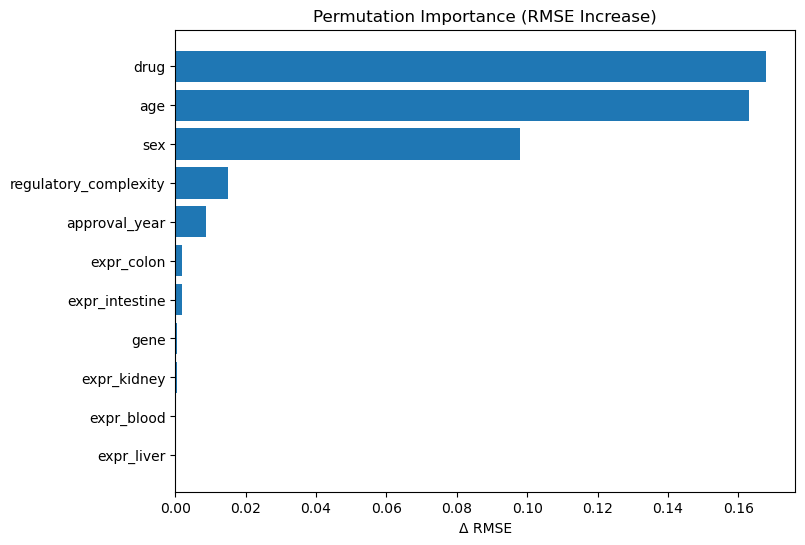

In [47]:
idx_perm = np.random.choice(len(X_val_sub), size=2000, replace=False)
X_perm = X_val_sub.iloc[idx_perm].copy()
y_perm = y_val_sub.iloc[idx_perm]
pool_perm = Pool(X_perm, y_perm, cat_features=["sex","drug","gene"])

base_pred = model.predict(pool_perm)
base_rmse = np.sqrt(((y_perm - base_pred)**2).mean())

perm_results = []

for f in feat_names:
    X_tmp = X_perm.copy()
    X_tmp[f] = np.random.permutation(X_tmp[f].values)
    pool_tmp = Pool(X_tmp, y_perm, cat_features=["sex","drug","gene"])
    pred_tmp = model.predict(pool_tmp)
    rmse_tmp = np.sqrt(((y_perm - pred_tmp)**2).mean())
    perm_results.append((f, rmse_tmp - base_rmse))

perm_df = pd.DataFrame(perm_results, columns=["feature","rmse_increase"])
perm_df = perm_df.sort_values("rmse_increase", ascending=False)

print(perm_df)

plt.figure(figsize=(8,6))
plt.barh(perm_df["feature"].iloc[::-1], perm_df["rmse_increase"].iloc[::-1])
plt.title("Permutation Importance (RMSE Increase)")
plt.xlabel("Δ RMSE")
plt.show()


In [48]:
idx_shap = np.random.choice(len(X_val_sub), size=2000, replace=False)
X_shap = X_val_sub.iloc[idx_shap]
pool_shap = Pool(X_shap, cat_features=["sex","drug","gene"])

shap_vals = model.get_feature_importance(
    pool_shap,
    type="ShapValues"
)

# shap_vals shape: [N, F+1], last column is expected_value
sv = shap_vals[:, :-1]
base_val = shap_vals[0, -1]

print("SHAP matrix shape:", sv.shape)
print("Base value (expected log1p count):", base_val)


SHAP matrix shape: (2000, 11)
Base value (expected log1p count): 1.7425460359448235


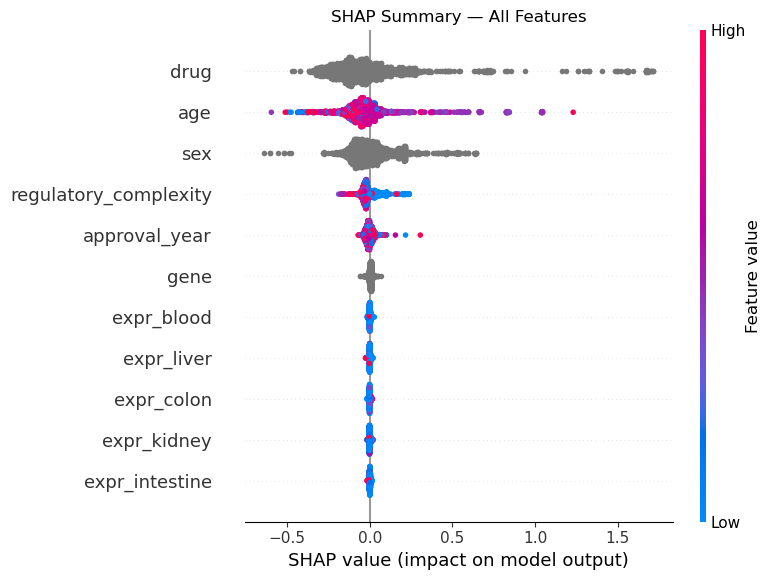

In [49]:
shap.summary_plot(sv, X_shap, feature_names=feat_names, show=False)
plt.title("SHAP Summary — All Features")
plt.tight_layout()
plt.savefig(
    "fig_model1_shap_summary.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

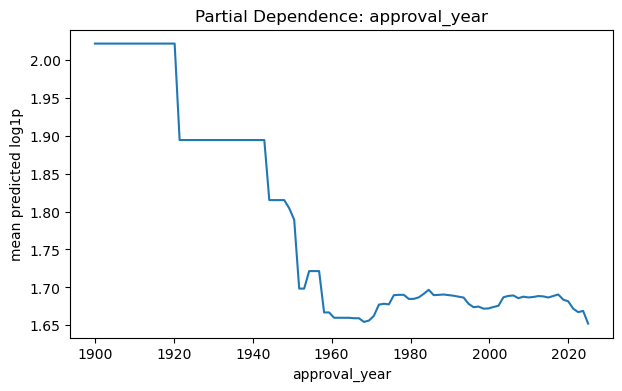

PD values (first 10): [np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761), np.float64(2.021858891657761)]


In [50]:
vals = np.linspace(X_train["approval_year"].min(), 
                   X_train["approval_year"].max(), 100)

df_pd = X_train.iloc[:1000].copy()
preds = []

for v in vals:
    df_tmp = df_pd.copy()
    df_tmp["approval_year"] = v
    pool_tmp = Pool(df_tmp, cat_features=["sex","drug","gene"])
    p = model.predict(pool_tmp).mean()
    preds.append(p)

plt.figure(figsize=(7,4))
plt.plot(vals, preds)
plt.title("Partial Dependence: approval_year")
plt.xlabel("approval_year")
plt.ylabel("mean predicted log1p")
plt.show()

print("PD values (first 10):", preds[:10])


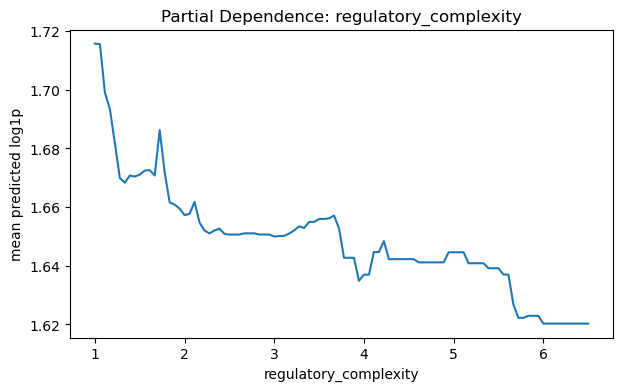

PD values (first 10): [np.float64(1.71565446973623), np.float64(1.7154538524218084), np.float64(1.6989873511637008), np.float64(1.6933585835709037), np.float64(1.6817366261996478), np.float64(1.6698541672485994), np.float64(1.668282509531982), np.float64(1.6707128764137447), np.float64(1.6703683907381872), np.float64(1.671029821545838)]


In [51]:
vals = np.linspace(X_train["regulatory_complexity"].min(), 
                   X_train["regulatory_complexity"].max(), 100)

df_pd = X_train.iloc[:1000].copy()
preds = []

for v in vals:
    df_tmp = df_pd.copy()
    df_tmp["regulatory_complexity"] = v
    pool_tmp = Pool(df_tmp, cat_features=["sex","drug","gene"])
    preds.append(model.predict(pool_tmp).mean())

plt.figure(figsize=(7,4))
plt.plot(vals, preds)
plt.title("Partial Dependence: regulatory_complexity")
plt.xlabel("regulatory_complexity")
plt.ylabel("mean predicted log1p")
plt.show()

print("PD values (first 10):", preds[:10])
